In [1]:
import itertools
from os.path import join
from time import perf_counter

import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from detectordescriptor import DetectorDescriptor
from utils import get_files_from_array

/usr/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def run_test(images):
    """Run the speed test"""
    count = 0
    detectors_s = []
    descriptors_s = []
    times = []
    nkps = []

    det_s, des_s = DetectorDescriptor.det_s, DetectorDescriptor.des_s

    for detector, descriptor in itertools.product(det_s, des_s):
        count += 1
        label = "{}/{}".format(detector, descriptor)
        print("Running test {}/{} - {}/{}".format(count,
                                                  len(det_s) * len(des_s),
                                                  detector, descriptor))

        algo = DetectorDescriptor(detector, descriptor)
        if algo.desc is None:
            print("Invalid combination - {}/{}".format(detector, descriptor))
            continue

        for image in images:
            start = perf_counter()
            keypoints = algo.detect(image)
            keypoints = algo.compute(image, keypoints)[0]
            end = perf_counter()

            detectors_s.append(detector)
            descriptors_s.append(descriptor)
            times.append((end - start) * 1000) # Milliseconds
            nkps.append(len(keypoints))

    return pd.DataFrame({'detector': detectors_s, 'descriptor': descriptors_s,
                        'time': times, 'nkp': nkps})

def generate_plots(data):
    """ Generate single detector plots, and save to PDF."""
    for detector in DetectorDescriptor.det_s:
        df = data[data.detector == detector]

        fig, ax = plt.subplots()

        sns.swarmplot(data=df, x='descriptor', y='time', ax=ax)

        ax.set_title("Detector = {}".format(detector))
        ax.set(xlabel="Descriptor", ylabel="Time taken / ms")
        ax.set(yscale='log', ylim=(1, data.time.max()))
        ax.grid(which='major', axis='y')
        ax.grid(which='minor', axis='y', linestyle=':', linewidth='0.5')

        fig.savefig(join("results", "speed", detector.lower() + ".pdf"))

def generate_heatmap(data):
    """Generate heatmap with all combinations of detector and descriptor."""
    # Heatmap
    fig, ax = plt.subplots()

    df = data.pivot_table(['nkp', 'time'], ['detector', 'descriptor'], aggfunc=np.sum)
    df = ((df.time / df.nkp) * 1000).unstack()
    df = df.replace(np.inf, np.nan)

    sns.heatmap(df, vmin=0, cmap='viridis_r', annot=True, fmt=".0f", ax=ax)
    ax.set_title("Speed test")
    ax.minorticks_on()

    fig.savefig(join("results", "speed.pdf"))
    return fig

In [3]:
dirs = ['bark', 'bikes', 'boat', 'graf', 'leuven', 'trees', 'ubc', 'wall']

files = get_files_from_array(dirs)
images = [cv2.imread(image, 0) for image in files]
data = run_test(images)

Running test 1/110 - Agast/AKAZE
Invalid combination - Agast/AKAZE
Running test 2/110 - Agast/BRISK
Running test 3/110 - Agast/KAZE
Invalid combination - Agast/KAZE
Running test 4/110 - Agast/ORB
Running test 5/110 - Agast/BRIEF
Running test 6/110 - Agast/DAISY
Running test 7/110 - Agast/FREAK
Running test 8/110 - Agast/LATCH
Running test 9/110 - Agast/SIFT
Running test 10/110 - Agast/SURF
Running test 11/110 - AKAZE/AKAZE
Running test 12/110 - AKAZE/BRISK
Running test 13/110 - AKAZE/KAZE
Running test 14/110 - AKAZE/ORB
Running test 15/110 - AKAZE/BRIEF
Running test 16/110 - AKAZE/DAISY
Running test 17/110 - AKAZE/FREAK
Running test 18/110 - AKAZE/LATCH
Running test 19/110 - AKAZE/SIFT
Running test 20/110 - AKAZE/SURF
Running test 21/110 - BRISK/AKAZE
Invalid combination - BRISK/AKAZE
Running test 22/110 - BRISK/BRISK
Running test 23/110 - BRISK/KAZE
Invalid combination - BRISK/KAZE
Running test 24/110 - BRISK/ORB
Running test 25/110 - BRISK/BRIEF
Running test 26/110 - BRISK/DAISY
Runn

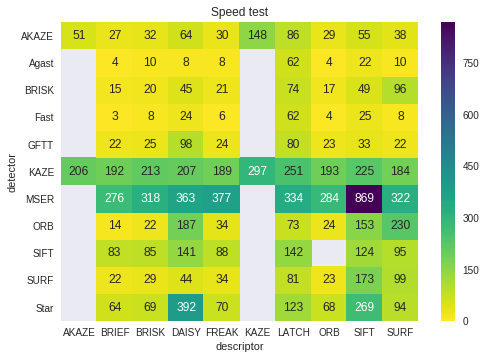

In [4]:
sns.reset_orig()
generate_plots(data)

sns.set()
display(generate_heatmap(data))